# **Config**

In [1]:
!pip install -q pysastrawi
!pip install -q nltk
!pip install -q catboost
!pip install -q xgboost
!pip install -q tensorflow_text tensorflow_hub
!pip install -q tf-keras
!pip install -q transformers
!pip install -q gradio-client
!pip install -q deep_translator

In [2]:
import sklearn
import plotly
import keras
import nltk
import Sastrawi
import re
import wordcloud
import string
import torch
import imblearn
import deep_translator
import json
import requests
import concurrent.futures
import itertools
import csv
import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import tf_keras as tfk
import tensorflow_hub as tfhub
import tensorflow_text as tftext

from nltk.corpus import wordnet
from torch import nn
from deep_translator import GoogleTranslator
from gradio_client import Client
from tqdm import tqdm
from bs4 import BeautifulSoup
from multiprocessing import Pool
from wordcloud import WordCloud, STOPWORDS
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import (
    AutoModelForSequenceClassification,
    get_scheduler,
    RobertaTokenizer,
    TFAutoModel,
    AdamWeightDecay,
    AdamW,
    BertTokenizer,
    TFBertModel,
    AutoTokenizer,
    AutoModel,
    DistilBertTokenizer,
    TFDistilBertModel
)
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import os
os.environ['TF_USE_LEGACY_KERAS'] = "1"

import warnings
warnings.filterwarnings('ignore')

2024-07-30 07:50:17.679047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 07:50:17.679211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 07:50:17.830261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Prepare Dataset**

In [5]:
train_df = pd.read_csv('https://raw.githubusercontent.com/mzkki25/pemilu-multiclass-text-classif/main/dataset_penyisihan_bdc_2024.csv')
test_df = pd.read_excel('https://raw.githubusercontent.com/mzkki25/pemilu-multiclass-text-classif/main/dataset_unlabeled_penyisihan_bdc_2024.xlsx')
train_df['text'] = train_df['text'].astype(np.str_)
test_df['text'] = test_df['text'].astype(np.str_)

In [66]:
# Duplikasi per baris
duplicates = train_df[train_df.duplicated(keep=False)]
duplicates['duplicate_key'] = duplicates.apply(lambda row: tuple(row), axis=1)
grouped_duplicates = duplicates.groupby('duplicate_key')
for key, group in grouped_duplicates:
    print(key, group)
    print("\n")

('@gQ+QGmYJ209N7Py+H3gRyakQiic4NLEklTOIIuALnZA= @gqAL2HIcdWKR2U/VFUq3R0TFxXxtxCsKyUXAKn9R5o0= Iya nih penting suara Batak sebagai populasi etnis ketiga terbesar setelah Jawa Sunda. Mayoritas Batak Kristen cukup anti sama Anies karena diframing radikal sejak', 'Demografi')                                                    text      label  \
1967  @gQ+QGmYJ209N7Py+H3gRyakQiic4NLEklTOIIuALnZA= ...  Demografi   
3844  @gQ+QGmYJ209N7Py+H3gRyakQiic4NLEklTOIIuALnZA= ...  Demografi   

                                          duplicate_key  
1967  (@gQ+QGmYJ209N7Py+H3gRyakQiic4NLEklTOIIuALnZA=...  
3844  (@gQ+QGmYJ209N7Py+H3gRyakQiic4NLEklTOIIuALnZA=...  


('Adi menginformasikan bahwa isu utama di kampung mereka adalah sulitnya mendapatkan air bersih dan masalah naiknya air laut. #IndonesiaSentris #IndonesiaHijau #02Melanjutkan #AnakMudaIndonesiaEmas Prabowo Subianto', 'Sumber Daya Alam')                                                    text             label  \
1028  Adi menginformasikan

In [67]:
# Duplikasi text sama label berbeda
grouped_by_text = train_df.groupby('text')

groups_with_different_labels = []

for text, group in grouped_by_text:
    if group['label'].nunique() > 1:
        groups_with_different_labels.append(group)

for group in groups_with_different_labels:
    print(group)
    print("\n")

In [6]:
train_df.drop_duplicates(subset=['text', 'label'], keep='first', inplace=True)

# **Visualize Data**

## **Label Distribution**

In [7]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x = train_df['label'].value_counts().index,
    y = train_df['label'].value_counts().values,
    marker_color=px.colors.qualitative.Dark24,
))

fig.update_layout(
    title = 'Banyak Data pada Data Target',
    xaxis_title = 'Data Target',
    yaxis_title = 'Banyak Data'
)

fig.show()

## **Text Distribution**

In [87]:
def get_top_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

    words, freqs = zip(*words_freq)

    plt.figure(figsize=(n, n//2))
    sns.barplot(x=list(freqs), y=list(words), palette='viridis')

    for i, txt in enumerate(freqs):
        plt.text(txt, i, txt, ha='left', va='center', color='black')

    plt.title(f'Top {n} {g}-grams')
    plt.xlabel('Frequency')
    plt.ylabel(f'{g}-grams')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='x')
    plt.show()


In [71]:
def get_top_unigram_based_on_label(corpus, n):
    labels = corpus['label'].unique().tolist()
    num_labels = len(labels)

    ncols = 3
    nrows = (num_labels + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))
    axes = axes.flatten()

    for i, label in enumerate(labels):
        vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus[corpus['label'] == label]['text'])
        bag_of_words = vec.transform(corpus[corpus['label'] == label]['text'])

        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

        words, freqs = zip(*words_freq)

        sns.barplot(x=list(freqs), y=list(words), palette='viridis', ax=axes[i])

        axes[i].set_title(f'Top {n} unigrams in {label}')
        axes[i].set_xlabel('Frequency')
        axes[i].set_ylabel('Unigrams')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].tick_params(axis='y', rotation=45)
        axes[i].grid(axis='x')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [72]:
def visualize_word_cloud(df):
    labels = df['label'].unique().tolist()
    num_labels = len(labels)

    ncols = 3
    nrows = (num_labels + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))
    axes = axes.flatten()

    for i, label in enumerate(labels):
        text_data = " ".join(df[df['label'] == label].text)
        wc = WordCloud(max_words=2000, width=800, height=400, stopwords=STOPWORDS, margin=1).generate(text_data)
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].set_title(label)
        axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# **Text Preprocessing**

## **Find OOV**

In [73]:
def cek_kata_di_kbbi(kata):
    url = f"https://kbbi.web.id/{kata}"
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            return False
        soup = BeautifulSoup(response.text, 'html.parser')
        d1_element = soup.find('div', id='d1')
        if d1_element and not d1_element.text.strip():
            return False
        return True
    except requests.exceptions.RequestException:
        return False

kata_train = list(set(" ".join(train_df['text'].tolist()).split()))
kata_test = list(set(" ".join(test_df['text'].tolist()).split()))

kata_kata = list(set(kata_train + kata_test))

kata_oov = []
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    futures = {executor.submit(cek_kata_di_kbbi, kata): kata for kata in kata_kata}
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Mengecek kata di KBBI"):
        kata = futures[future]
        if not future.result():
            kata_oov.append(kata)

set_kata_oov = list(set(kata_oov))
print(f"Kata OOV: {set_kata_oov}")

Mengecek kata di KBBI:   0%|          | 0/34733 [00:00<?, ?it/s]

Kata OOV: ['sengklek', 'https://t.co/mVpGKblPh5', 'digenosida', '@TJ4kqDfnrv1iWzzdznCIL0w0W5jK246D8UA9mF9eosY=', 'https://t.co/YoiTYO4hqp', 'hack.', 'https://t.co/ge5W2ptgZb', '@QIV82JHjEMubWB1ScRapZb898Fu/sZsYox+5OQDlEsY=', '#puanmaharani', 'ditindaklanjuti', 'edarannya.', 'siAnies', 'disimak', 'diusulkan', 'Seribuan', 'kepake', 'https://t.co/9AvoTa6ssU', 'komoditasnya,', '#ganjarlebihbaik', 'Draft', 'nuhun', '@0heR/3WzDvBmU9BD5YAx1eAfPQz+akiVlNt7YbP42M0=', 'berjoged', 'Politica', 'https://t.co/4Ugus7cXC9', 'AnKiiim_]', 'opung', 'BLT:', 'SPT', 'https://t.co/ndhD7qjE1F', 'Fyi.', 'ÃƒÂ°Ã‚Å¸Ã‚â€œÃ‚Â\x8dJakarta', 'tanggalnya,', 'Watch:', 'Posyandu', '@ainunnajib', 'mundurnya', 'sekelilingnya.', 'Listening', 'diarea', 'https://t.co/GUGz2HlUr5', 'Papua.', 'GOlKAR', 'pgn', 'pencitraan', 'https://t.co/B1YfFqRWDz', 'ditantang', 'https://t.co/Vkbcwwm5Be', 'dikorbankan', '@marsyafilzah', 'https://t.co/iFCKbkp7B8', 'terukur.#GanjarMahfudRebound', 'Lalalalala,"', 'slow', 'ÃƒÂ°Ã‚Å¸Ã‚Å½Ã‚Â¿', '#Insya

In [ ]:
with open('oov-fiks.txt', 'w', encoding='utf-8') as file:
    for kata in set_kata_oov:
        file.write(kata + '\n')

print("Kata OOV telah disimpan ke dalam file 'oov.txt'")

## **Spell Checker**

In [ ]:
oov = pd.read_csv('oov-fiks.txt', header=None, names=['oov'])
oov.to_csv('oov-fiks.csv', index=False)

In [ ]:
def qwen2(message):
    client = Client("Qwen/Qwen2-72B-Instruct")
    result = client.predict(
        query=message,
        history=[],
        system=f"text yang diinputkan adalah teks out of vocabulary, tuliskan revisi dari teks out of vocabulary tersebut menggunakan bahasa indonesia, atau tulis 'tidak diketahui' jika tidak ada arti dari teks tersebut menggunakan huruf kecil semua. Kamu hanya berhak menuliskan outputnya dalam 1 kata saja, tidak boleh menuliskan kata kata lainnya selain teks hasil revisi tersebut",
        api_name="/model_chat"
    )
    return result[1][0][1]

In [ ]:
with open("oov-fiks.csv", "r") as csvfile:
    reader = csv.DictReader(csvfile)

    fieldnames = [field for field in reader.fieldnames if field not in ["true"]]
    fieldnames.append("true")

    with open("oov-true.csv", "w", newline="") as outfile:
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()

        for i, row in enumerate(reader):
            tweet = row["oov"]
            prompt_label = f"text '{tweet}' adalah teks oov, tuliskan hanya kata yang benar dari oov tersebut, atau tulis 'tidak diketahui' jika tidak ada arti dari teks tersebut. Kamu hanya berhak menuliskan outputnya dalam 1 kata saja"

            row["prompt_qwen"] = prompt_label

            try:
                response = qwen2(tweet)
                print(f"{i+1}: {response}")
            except Exception as e:
                print("Exception occurred during conversation:", e)
                response = None

            row.pop("prompt_qwen", None)

            if response is None:
                print("response is None")
                row["true"] = "No Label"
            else:
                row["true"] = response

            writer.writerow(row)

## **Handling OOV**

In [8]:
url1 = "https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv"
url2 = 'https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/kbba.txt'
url3 = "https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/new_kamusalay.csv"
url4 = "https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/acronym.txt"
url5 = "https://raw.githubusercontent.com/panggi/pujangga/master/resource/formalization/formalizationDict.txt"
url6 = "https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt"
url7 = "https://raw.githubusercontent.com/mzkki25/pemilu-multiclass-text-classif/main/combined_slang_word.txt"
url8 = "https://raw.githubusercontent.com/mzkki25/pemilu-multiclass-text-classif/main/slang.txt"
url9 = 'https://raw.githubusercontent.com/mzkki25/pemilu-multiclass-text-classif/main/oov-true.csv'

oov = pd.read_csv(url9, delimiter=";")
oov['kalimat_true'] = oov['kalimat_true'].replace({'tidak diketahui':" "})
oov = dict(zip(oov['oov'], oov['kalimat_true']))
print(len(oov), type(oov))

slang = pd.read_csv(url8, sep=' : ', header=None)
slang.dropna(inplace=True)
slang = slang.rename(columns={0: 'original', 1: 'replacement'})
slang1 = dict(zip(slang['original'], slang['replacement']))
print(len(slang1), type(slang1))

combined_slang = pd.read_json(url7, orient='index')
slang2 = combined_slang[0].to_dict()
print(len(slang2), type(slang2))

kamusalay = pd.read_csv(url3, header=None, names=['slang', 'formal'], encoding='ISO-8859-1')
kamusalay.dropna(inplace=True)
slang3 = dict(zip(kamusalay['slang'], kamusalay['formal']))
print(len(slang3), type(slang3))

kbba = pd.read_csv(url2, sep='\t', header=None, names=['singkat', 'formal'])
kbba.dropna(inplace=True)
slang4 = dict(zip(kbba['singkat'], kbba['formal']))
print(len(slang4), type(slang4))

lexicon = pd.read_csv(url1)
lexicon.dropna(inplace=True)
lexicon = lexicon[['slang', 'formal']]
slang5 = dict(zip(lexicon['slang'], lexicon['formal']))
print(len(slang5), type(slang5))

formalization = pd.read_csv(url5, sep='\t', header=None, names=['slang', 'formal'])
formalization.dropna(inplace=True)
slang6 = dict(zip(formalization['slang'], formalization['formal']))
print(len(slang6), type(slang6))

4191 <class 'dict'>
1620 <class 'dict'>
1018 <class 'dict'>
15167 <class 'dict'>
1290 <class 'dict'>
4331 <class 'dict'>
1135 <class 'dict'>


In [9]:
combined_slang = {**slang1, **slang2, **slang3, **slang4, **slang5, **slang6, **oov}
combined_slang = pd.DataFrame(combined_slang.items(), columns=['original', 'replacement'])
combined_slang = dict(zip(combined_slang['original'], combined_slang['replacement']))
print(len(combined_slang), type(combined_slang))

20562 <class 'dict'>


In [10]:
stopwords_id = pd.read_csv(url6, header=None, names=['stopword'])
stopwords_id = stopwords_id['stopword'].tolist()
print(len(stopwords_id), type(stopwords_id))

758 <class 'list'>


## **Feature Extraction**

In [11]:
def oov_handler(slang, text):
    res = " ".join(slang.get(ele, ele) for ele in text.split())
    return res

def cleaning_text(text):
    text = re.sub(r'x00[0-9a-fA-F]{2}', '', text)           # Menghapus pola x00XX
    text = re.sub(r'[^\x00-\x7F]+', '', text)               # remove non-ascii characters (emoticon, emoji, etc.)
    text = re.sub(r'\[RE [^\]]+\]', '', text)               # remove RE
    text = re.sub(r'@[A-Za-z0-9+/=]+', '', text)            # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)               # remove hashtag
    text = re.sub(r'<[^>]+>', '', text)                     # remove HTML tags
    text = re.sub(r'RT[\s]', '', text)                      # remove RT
    text = re.sub(r"http\S+", '', text)                     # remove link
    text = re.sub(r'[0-9]+', '', text)                      # remove numbers
    text = re.sub(r'\n', ' ', text)                         # remove newline
    text = re.sub(r'[^\w\s]', '', text)                     # remove all punctuations
    text = re.sub(r'[%-+]', ' ', text)                      # Menghapus karakter %, - dan +
    text = re.sub(r'^\s+|\s+$', '', text)                   # remove characters space from both left and right text
    text = text.lower()                                     # convert text into lowercase
    text = oov_handler(combined_slang, text)                # convert informal words into formal words
    text = re.sub(r'anies|baswedan|imin|prabowo|subianto|ganjar|pranowo|mahfud|md|gibran|rakabuming|jokowi|joko|widodo', ' ', text)
    text = text.lower()                                     # convert text into lowercase
    text = re.sub(r' +', ' ', text)                         # remove extra spaces
    return text

def tokenizing_text(text):
    return word_tokenize(text)

def stop_word_text(text):
    stopword = StopWordRemoverFactory().get_stop_words() + stopwords.words('indonesian') + stopwords_id
    stopword = list(set(stopword))
    stopword = [word.lower() for word in stopword]
    split_text = text.split() if isinstance(text, str) else text
    return [word for word in split_text if word not in stopword]

def stemming_text(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def combined_text(text):
    return ' '.join(text)

In [12]:
nltk.download('stopwords')
nltk.download('punkt')

def apply_preprocess(df):
    df['text'] = df['text'].apply(cleaning_text)
    df['text'] = df['text'].apply(tokenizing_text)
    df['text'] = df['text'].apply(stop_word_text)
    df['text'] = df['text'].apply(stemming_text)
    df['text'] = df['text'].apply(combined_text)

apply_preprocess(train_df)
apply_preprocess(test_df)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Duplikasi per baris
duplicates = train_df[train_df.duplicated(keep=False)]
duplicates['duplicate_key'] = duplicates.apply(lambda row: tuple(row), axis=1)
grouped_duplicates = duplicates.groupby('duplicate_key')
for key, group in grouped_duplicates:
    print(key, group)
    print("\n")

In [79]:
# Duplikasi text sama label berbeda
grouped_by_text = train_df.groupby('text')

groups_with_different_labels = []

for text, group in grouped_by_text:
    if group['label'].nunique() > 1:
        groups_with_different_labels.append(group)

for group in groups_with_different_labels:
    print(group)
    print("\n")

     text             label
74            Sosial Budaya
552                 Politik
943           Sosial Budaya
1157                Politik
1952               Geografi
1970       Sumber Daya Alam
2648                Politik
2660       Sumber Daya Alam
3307                Ekonomi
3891                Politik
3929                Politik
4783          Sosial Budaya




In [13]:
train_df = train_df[train_df['text'] != ""]
train_df.drop_duplicates(subset=['text', 'label'], keep='first', inplace=True)

## **Get Top N-Grams**

In [81]:
fig=go.Figure()

fig.add_trace(go.Bar(
    x=train_df['label'].value_counts().index,
    y=train_df['label'].value_counts().values,
    marker_color=px.colors.qualitative.Dark24,
))

fig.update_layout(
    title='Banyak Data pada Data Target',
    xaxis_title='Data Target',
    yaxis_title='Banyak Data'
)

fig.show()

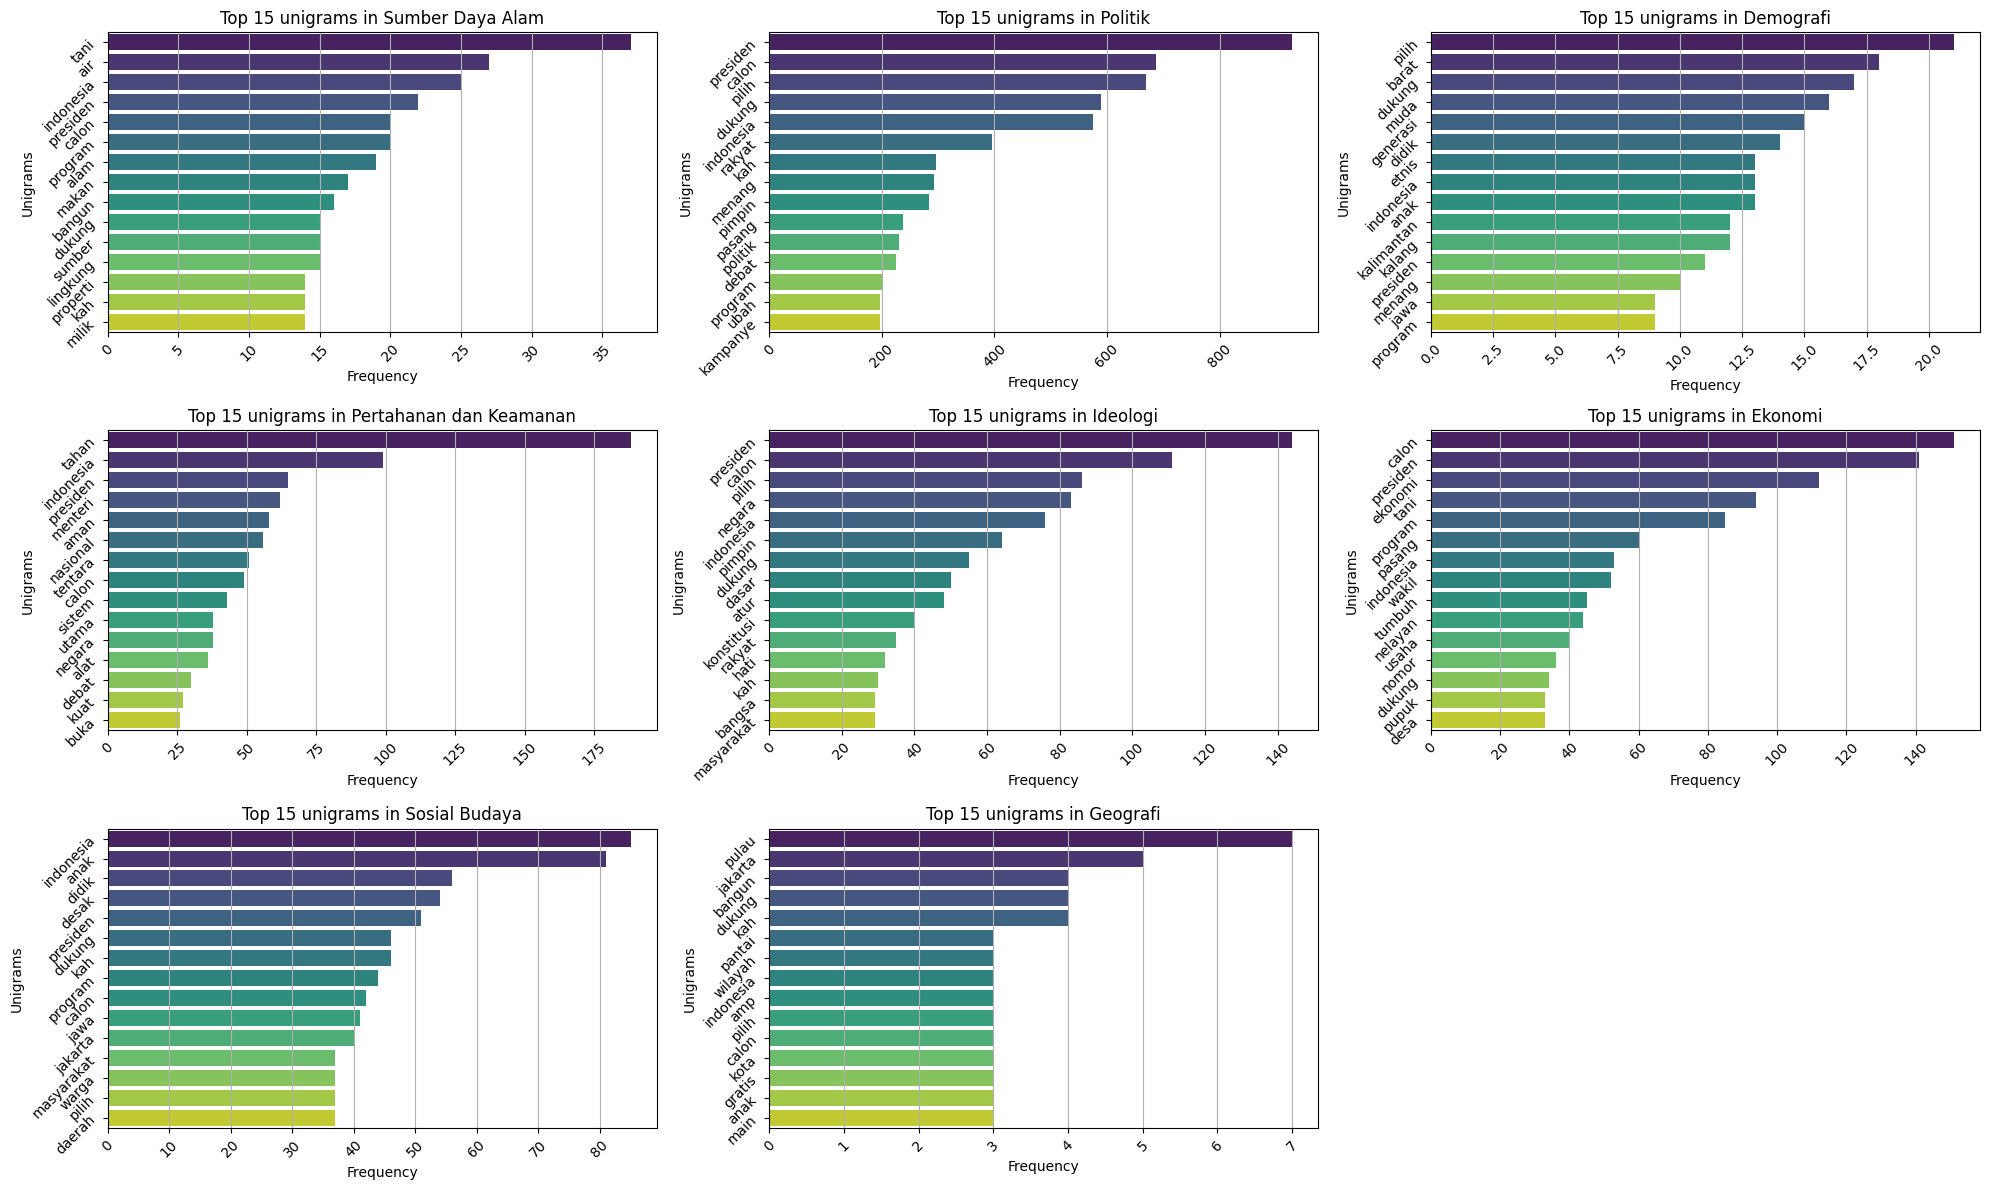

In [82]:
get_top_unigram_based_on_label(train_df, 15)

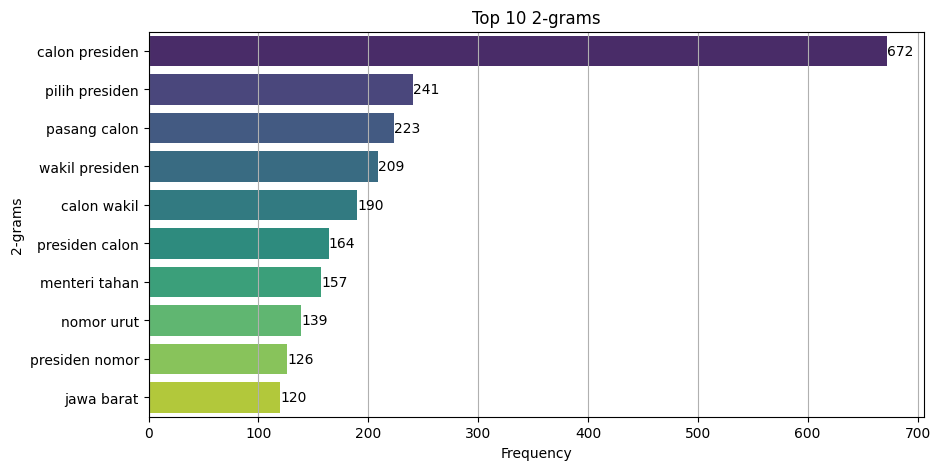

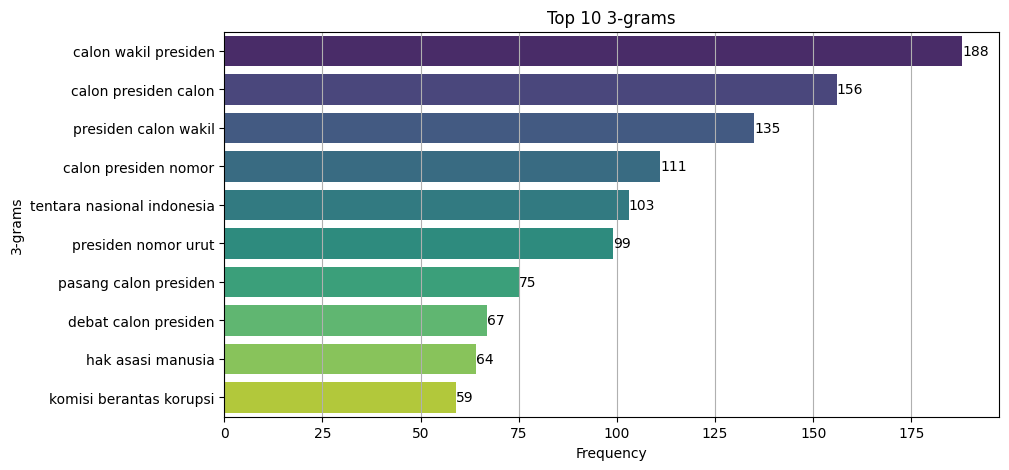

In [88]:
get_top_ngrams(train_df['text'], 10, 2)
get_top_ngrams(train_df['text'], 10, 3)

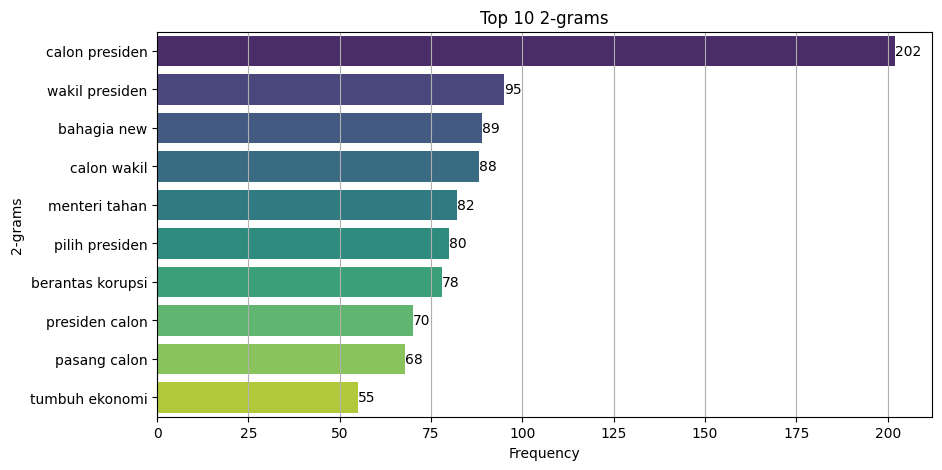

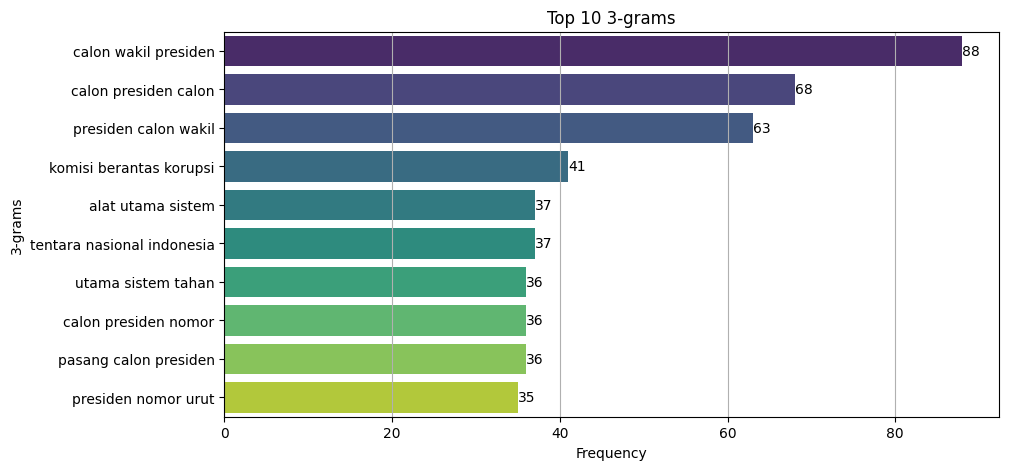

In [89]:
get_top_ngrams(test_df['text'], 10, 2)
get_top_ngrams(test_df['text'], 10, 3)

## **Word Cloud**

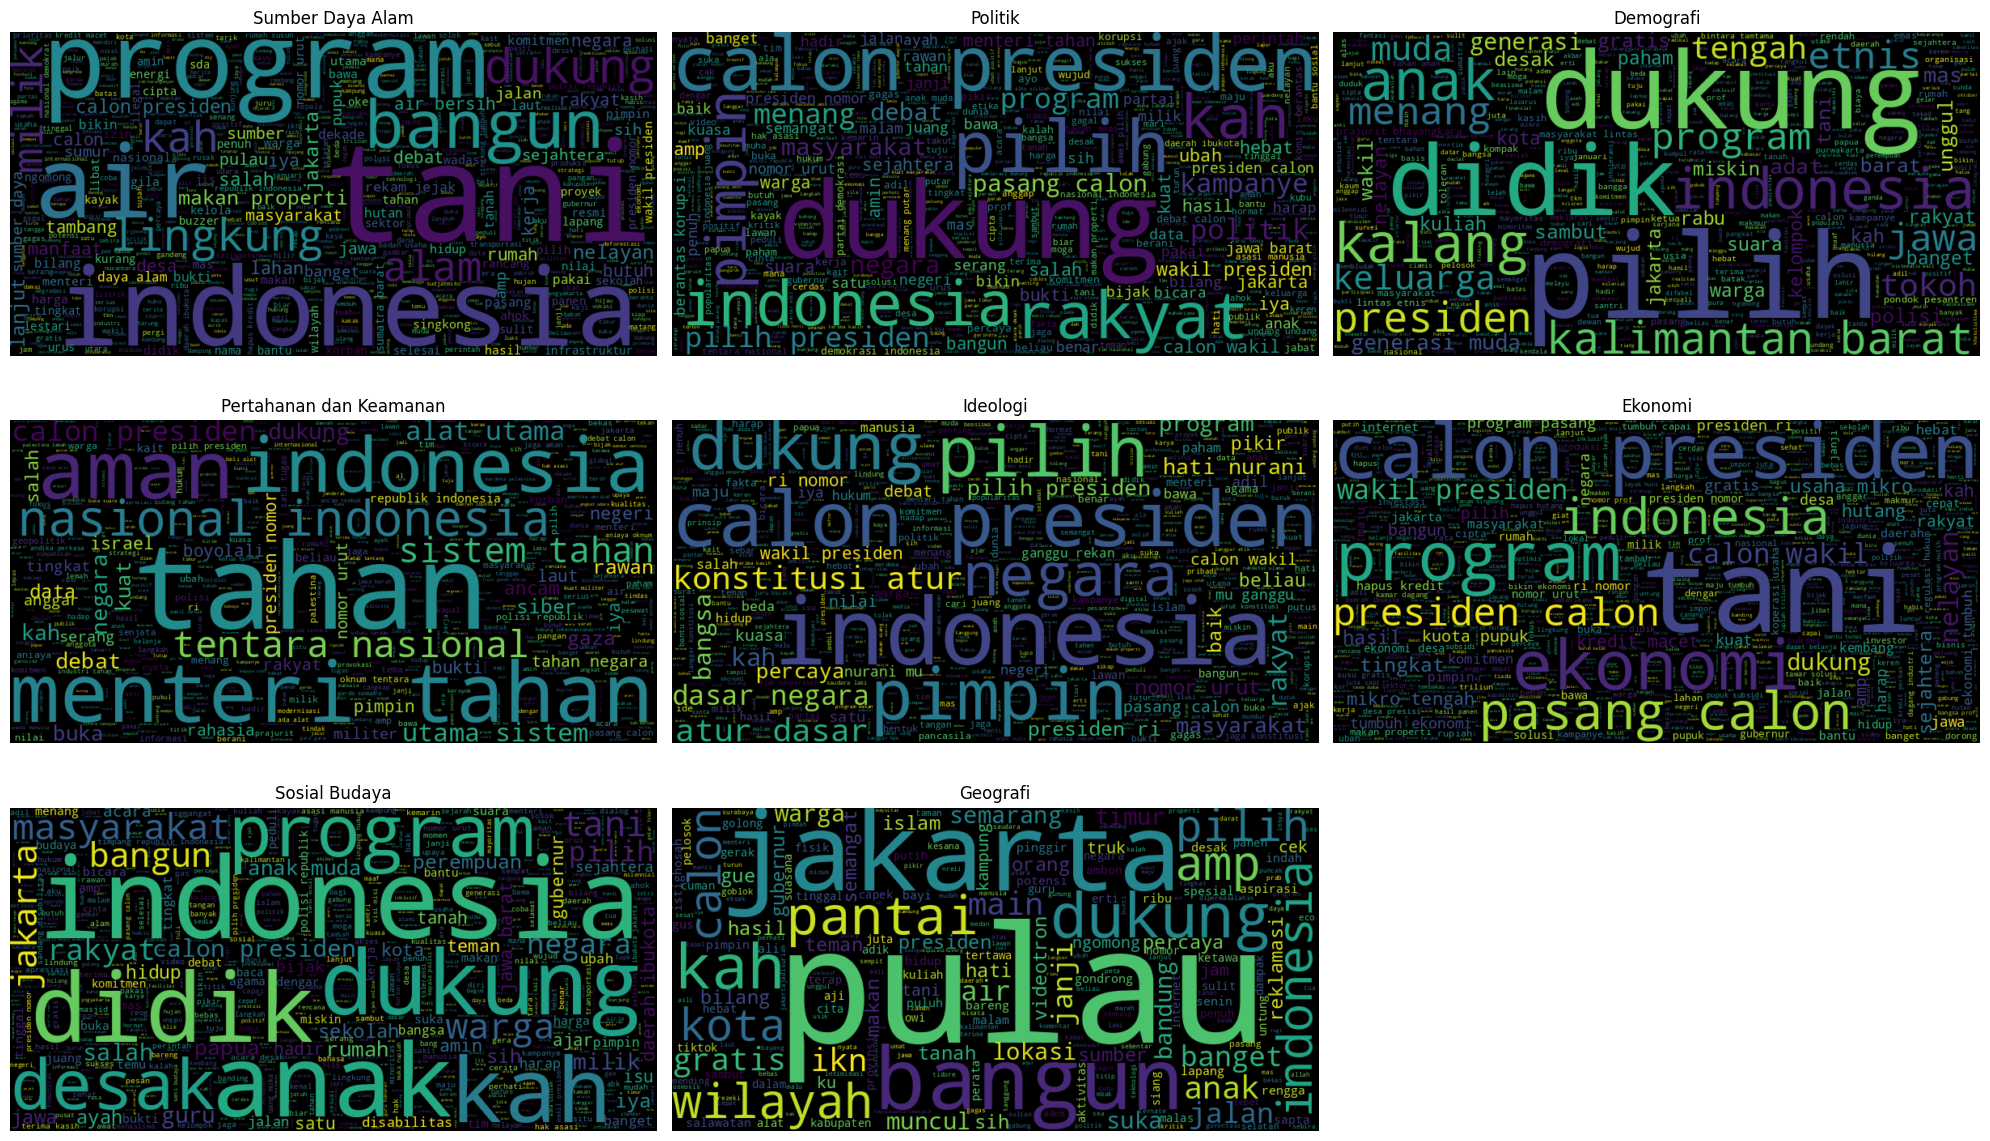

In [90]:
visualize_word_cloud(train_df)

In [ ]:
train_df.to_csv("./cleaned_dataset_penyisihan_bdc_2024.csv", index=False)
test_df.to_csv("./cleaned_dataset_unlabeled_penyisihan_bdc_2024.csv", index=False)

# **Text Modelling**

In [91]:
train_df = pd.read_csv("./cleaned_dataset_penyisihan_bdc_2024.csv")
test_df = pd.read_csv("./cleaned_dataset_unlabeled_penyisihan_bdc_2024.csv")
train_df.dropna(inplace=True)
train_df.shape, test_df.shape

((15344, 2), (1000, 2))

## **Back Translation (ID-EN)**

In [14]:
def translate_text(text):
    translated_text = GoogleTranslator(source='id', target='en').translate(text)
    return translated_text.lower()

def apply_back_translation(df, num_workers=20):
    texts = df['text'].tolist()
    translated_texts = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_text = {executor.submit(translate_text, text): text for text in texts}
        for future in tqdm(concurrent.futures.as_completed(future_to_text), total=len(texts)):
            translated_texts.append(future.result())

    df['text'] = translated_texts
    return df

# train_df = apply_back_translation(train_df)
test_df = apply_back_translation(test_df)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
train_df.to_csv("./cleaned_dataset_penyisihan_bdc_2024_1.csv", index=False)
test_df.to_csv("./cleaned_dataset_unlabeled_penyisihan_bdc_2024_1.csv", index=False)

## **Synonim Replacement**

In [ ]:
train_df = pd.read_csv("./cleaned_dataset_penyisihan_bdc_2024_1.csv")
test_df = pd.read_csv("./cleaned_dataset_unlabeled_penyisihan_bdc_2024_1.csv")
train_df.dropna(inplace=True)

In [ ]:
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [ ]:
def synonym_replacement(sentence, n):
    words = sentence.split()
    new_sentence = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0

    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            new_sentence = [synonym if word == random_word else word for word in new_sentence]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_sentence)

def augment_minority_class(df, n_replacements=2):
    augmented_texts = []
    augmented_labels = []

    for label in df['label'].unique():
        subset = df[df['label'] == label]
        if len(subset) < df['label'].value_counts().max():
            num_to_generate = df['label'].value_counts().max() - len(subset)
            for _ in range(num_to_generate):
                row = subset.sample(n=1).iloc[0]
                augmented_text = synonym_replacement(row['text'], n_replacements)
                augmented_texts.append(augmented_text)
                augmented_labels.append(row['label'])

    return pd.DataFrame({
        'text' : augmented_texts,
        'label': augmented_labels
    })

train_df = pd.concat([
    train_df, augment_minority_class(train_df)
])

In [ ]:
train_df.drop_duplicates(inplace=True)
train_df['label'].value_counts().reset_index()

## **Word Importance**

In [15]:
def count_unique_words(train_df):
    unique_word_counts = {}

    grouped = train_df.groupby('label')

    for label, group in grouped:
        text_data = group['text'].str.cat(sep=' ')
        words = set(text_data.split())
        unique_word_counts[label] = len(words)

    sorted_counts = {k: v for k, v in sorted(unique_word_counts.items(), key=lambda item: item[1], reverse=True)}

    return sorted_counts

unique_words = count_unique_words(train_df)
unique_words

{'Politik': 4680,
 'Sosial Budaya': 2855,
 'Ekonomi': 2724,
 'Pertahanan dan Keamanan': 2598,
 'Ideologi': 2546,
 'Sumber Daya Alam': 1938,
 'Demografi': 1406,
 'Geografi': 1008}

In [ ]:
def apply_word_frequency_train(train_df):
    label_words = {
        'Politik': [],
        'Sosial Budaya': [],
        'Ekonomi': [],
        'Pertahanan dan Keamanan': [],
        'Ideologi': [],
        'Sumber Daya Alam': [],
        'Demografi': [],
        'Geografi': []
    }

    grouped = train_df.groupby('label')

    for label, group in grouped:
        text_data = group['text'].str.cat(sep=' ')
        words = text_data.split()
        word_freq = Counter(words)

        if label == 'Politik':
            label_words['Politik'] = [word for word, _ in word_freq.most_common(int(unique_words['Politik']/16))]
        elif label == 'Sosial Budaya':
            label_words['Sosial Budaya'] = [word for word, _ in word_freq.most_common(int(unique_words['Sosial Budaya']/14))]
        elif label == 'Ideologi':
            label_words['Ideologi'] = [word for word, _ in word_freq.most_common(int(unique_words['Ideologi']/12))]
        elif label == 'Pertahanan dan Keamanan':
            label_words['Pertahanan dan Keamanan'] = [word for word, _ in word_freq.most_common(int(unique_words['Pertahanan dan Keamanan']/10))]
        elif label == 'Ekonomi':
            label_words['Ekonomi'] = [word for word, _ in word_freq.most_common(int(unique_words['Ekonomi']/8))]
        elif label == 'Sumber Daya Alam':
            label_words['Sumber Daya Alam'] = [word for word, _ in word_freq.most_common(int(unique_words['Sumber Daya Alam']/6))]
        elif label == 'Demografi':
            label_words['Demografi'] = [word for word, _ in word_freq.most_common(int(unique_words['Demografi']/4))]
        elif label == 'Geografi':
            label_words['Geografi'] = [word for word, _ in word_freq.most_common(int(unique_words['Geografi']/2))]

    return label_words

label_words = apply_word_frequency_train(train_df.copy())

important_list = []
for words in label_words.values():
    important_list.extend(words)

important_list = list(set(important_list))

def filter_important_words(text, important_list):
    return ' '.join([word for word in text.split() if word in important_list])

In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: filter_important_words(x, important_list))
test_df['text'] = test_df['text'].apply(lambda x: filter_important_words(x, important_list))

In [ ]:
train_df.drop_duplicates(inplace=True)
train_df['label'].value_counts().reset_index()

## **Back Translation (EN-ID)**

In [16]:
def translate_text(text):
    translated_text = GoogleTranslator(source='en', target='id').translate(text)
    return translated_text.lower()

def apply_back_translation(df, num_workers=20):
    texts = df['text'].tolist()
    translated_texts = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_text = {executor.submit(translate_text, text): text for text in texts}
        for future in tqdm(concurrent.futures.as_completed(future_to_text), total=len(texts)):
            translated_texts.append(future.result())

    df['text'] = translated_texts
    return df

train_df = apply_back_translation(train_df)
test_df = apply_back_translation(test_df)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
val_df = pd.read_csv('/kaggle/input/dataset-penyisihan-bdc/labeled_dataset_penyisihan.csv')
val_df = pd.merge(test_df, val_df, on='IDText')
val_df = val_df[['text', 'Label']].rename(columns={'Label': 'label'})
train_df = pd.concat([train_df, val_df])
train_df

In [ ]:
train_df.to_csv('/kaggle/working/cleaned_dataset_penyisihan_bdc_2024_id_1.csv', index=False)
test_df.to_csv('/kaggle/working/cleaned_dataset_unlabeled_penyisihan_bdc_2024_id_1.csv', index=False)

## **Cleaning Text**

In [ ]:
train_df = pd.read_csv('/kaggle/working/cleaned_dataset_penyisihan_bdc_2024_id_1.csv')
test_df = pd.read_csv('/kaggle/working/cleaned_dataset_unlabeled_penyisihan_bdc_2024_id_1.csv')

In [17]:
nltk.download('stopwords')
nltk.download('punkt')

def apply_preprocess(df):
    df['text'] = df['text'].apply(cleaning_text)
    df['text'] = df['text'].apply(tokenizing_text)
    df['text'] = df['text'].apply(stop_word_text)
    df['text'] = df['text'].apply(stemming_text)
    df['text'] = df['text'].apply(combined_text)

apply_preprocess(train_df)
apply_preprocess(test_df)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
train_df = train_df[train_df['text'] != ""]
train_df['label'].value_counts().reset_index()

label  count
0                  Politik   3380
1                  Ekonomi   2058
2            Sosial Budaya   2021
3                 Ideologi   1996
4  Pertahanan dan Keamanan   1965
5         Sumber Daya Alam   1633
6                Demografi   1351
7                 Geografi    920

In [ ]:
def unique_words_per_label(df):
    text_by_label = df.groupby('label')['text'].apply(lambda texts: ' '.join(texts)).reset_index()
    
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text_by_label['text'])
    word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=text_by_label['label'])
    
    unique_words = {}
    for label in word_counts.index:
        other_labels = word_counts.index.difference([label])
        unique = word_counts.loc[label] > 0  # Kata muncul di label ini
        not_in_others = (word_counts.loc[other_labels] == 0).all()  # Kata tidak muncul di label lain
        unique_words[label] = word_counts.columns[unique & not_in_others].tolist()
    
    return unique_words

unique_words = unique_words_per_label(train_df)

for label, words in unique_words.items():
    print(f"Unique words for label '{label}': {words} \n\n")

In [ ]:
train_df.to_csv('/kaggle/working/cleaned_dataset_penyisihan_bdc_2024_id_1.csv', index=False)
test_df.to_csv('/kaggle/working/cleaned_dataset_unlabeled_penyisihan_bdc_2024_id_1.csv', index=False)

## **Prepare Dataset for Modelling**

In [18]:
train_df = pd.read_csv('/kaggle/working/cleaned_dataset_penyisihan_bdc_2024_id_1.csv')
test_df = pd.read_csv('/kaggle/working/cleaned_dataset_unlabeled_penyisihan_bdc_2024_id_1.csv')

In [19]:
def encode_target(target):
    target_tensor = tf.constant(target)

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant([
                'Politik', 'Sosial Budaya',
                'Ideologi', 'Pertahanan dan Keamanan',
                'Geografi', 'Ekonomi',
                'Sumber Daya Alam', 'Demografi'
            ]),
            values=tf.constant([0, 1, 2, 3, 4, 5, 6, 7]),
        ),
        default_value=tf.constant(-1),
        name="target_encoding"
    )

    return table.lookup(target_tensor)

def fetch(text, label):
    label = tf.cast(label, tf.int32)
    encoded_label = tf.one_hot(label, 8)
    return text, encoded_label

In [20]:
X_train, X_test = train_test_split(train_df.dropna(), test_size=0.2, random_state=None)

X_train['text'], X_train['label'] = X_train['text'].astype(str), encode_target(X_train['label'].tolist()).numpy()
X_test['text'], X_test['label'] = X_test['text'].astype(str), encode_target(X_test['label'].tolist()).numpy()

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train['text'].values, X_train['label'])
).map(lambda text, label: fetch(text, label))

test_dataset = tf.data.Dataset.from_tensor_slices(
    (X_test['text'].values, X_test['label'])
).map(lambda text, label: fetch(text, label))

train_data, train_label = next(iter(train_dataset.batch(len(train_dataset))))
test_data, test_label = next(iter(test_dataset.batch(len(test_dataset))))

train_data  = np.asarray([data.decode('utf-8') for data in np.asarray(train_data)])
train_label = np.asarray(train_label)
test_data   = np.asarray([data.decode('utf-8') for data in np.asarray(test_data)])
test_label  = np.asarray(test_label)

class_weights = compute_class_weight(
    class_weight ='balanced',
    classes=np.unique(X_train['label']),
    y=X_train['label']
)

class_weights = dict(zip(np.unique(X_train['label']), class_weights))

# **Model Training**

## **Using Simple RNN**

In [36]:
tfk.backend.clear_session()

encoder = tfk.layers.TextVectorization(max_tokens=1200)
encoder.adapt(train_data)

stacked_bi_lstm = tfk.Sequential([
    tfk.layers.Input(shape=(), dtype=tf.string),
    encoder,
    tfk.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True
    ),
    tfk.layers.Bidirectional(tfk.layers.LSTM(128, return_sequences=True)),
    tfk.layers.Bidirectional(tfk.layers.LSTM(64, return_sequences=True)),
    tfk.layers.Bidirectional(tfk.layers.LSTM(32)),
    tfk.layers.Dense(32, activation='relu'),
    tfk.layers.Dropout(0.2),
    tfk.layers.Dense(8, activation='softmax'),
])

stacked_bi_lstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

stacked_bi_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 128)         153600    
                                                                 
 bidirectional (Bidirection  (None, None, 256)         263168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 128)         164352    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                  

In [37]:
history = stacked_bi_lstm.fit(
    train_data, train_label,
    epochs=20,
    validation_data=(test_data, test_label),
    verbose=1,
    class_weight=class_weights
)

Epoch 1/20
384/384 [==============================] - 59s 85ms/step - loss: 1.7080 - accuracy: 0.2642 - val_loss: 1.6445 - val_accuracy: 0.3299
Epoch 2/20
384/384 [==============================] - 14s 37ms/step - loss: 1.3934 - accuracy: 0.3612 - val_loss: 1.5093 - val_accuracy: 0.3918
Epoch 3/20
384/384 [==============================] - 13s 34ms/step - loss: 1.2963 - accuracy: 0.4020 - val_loss: 1.4485 - val_accuracy: 0.4186
Epoch 4/20
384/384 [==============================] - 12s 32ms/step - loss: 1.2094 - accuracy: 0.4338 - val_loss: 1.4268 - val_accuracy: 0.4290
Epoch 5/20
384/384 [==============================] - 13s 33ms/step - loss: 1.1503 - accuracy: 0.4626 - val_loss: 1.3664 - val_accuracy: 0.4587
Epoch 6/20
384/384 [==============================] - 12s 32ms/step - loss: 1.0824 - accuracy: 0.5053 - val_loss: 1.3268 - val_accuracy: 0.4927
Epoch 7/20
384/384 [==============================] - 12s 32ms/step - loss: 1.0286 - accuracy: 0.5335 - val_loss: 1.3773 - val_accuracy:

In [38]:
y_pred = stacked_bi_lstm.predict(test_data)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_label, axis=1)

balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')

96/96 [==============================] - 9s 11ms/step
Balanced Accuracy: 0.6697331693869819


In [ ]:
stacked_bi_lstm.save('stacked_bi_lstm')

In [39]:
test_df = pd.read_csv('/kaggle/working/test.csv')
test_df['text'] = test_df['text'].astype(str)

unlabel_dataset = tf.data.Dataset.from_tensor_slices(
    test_df['text'].values
)

unlabel_data = next(iter(unlabel_dataset.batch(len(unlabel_dataset))))
unlabel_data = np.asarray([data.decode('utf-8') for data in np.asarray(unlabel_data)])

test_df['Label'] = np.argmax(stacked_bi_lstm.predict(unlabel_data), axis=1)

def decode_target(target):
    target_tensor = tf.constant(target)

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant([0, 1, 2, 3, 4, 5, 6, 7]),
            values=tf.constant([
                'Politik', 'Sosial Budaya',
                'Ideologi', 'Pertahanan dan Keamanan',
                'Geografi', 'Ekonomi', 'Sumber Daya Alam', 'Demografi'
            ]),
        ),
        default_value=tf.constant('Unknown'),
        name="target_decoding"
    )

    return table.lookup(target_tensor)

test_df['Label'] = decode_target(test_df['Label'].tolist()).numpy()
test_df['Label'] = test_df['Label'].str.decode('utf-8')
test_df = test_df[['IDText', 'Label']]
test_df.to_csv('test_rnn_sub.csv', index=False)
test_df['Label'].value_counts()

32/32 [==============================] - 0s 13ms/step


Label
Politik                    319
Ekonomi                    163
Sosial Budaya              158
Pertahanan dan Keamanan    148
Ideologi                    88
Sumber Daya Alam            57
Geografi                    35
Demografi                   32
Name: count, dtype: int64

## **Using NNLM**

In [28]:
tfk.backend.clear_session()

text_input = tfk.layers.Input(shape=(), dtype=tf.string, name='text_input')

embedding = tfhub.KerasLayer(
    handle='https://www.kaggle.com/models/google/nnlm/TensorFlow2/id-dim128-with-normalization/1',
    output_shape=[128],
    input_shape=[],
    dtype=tf.string,
    trainable=True,
    name='embedding'
)(text_input)

l = tfk.layers.Dense(128, activation='relu', name='dense_128')(embedding)
l = tfk.layers.Dropout(0.2, name='dropout_128')(l)
l = tfk.layers.Dense(64, activation='relu', name='dense_64')(l)
l = tfk.layers.Dropout(0.2, name='dropout_64')(l)
l = tfk.layers.Dense(32, activation='relu', name='dense_32')(l)
l = tfk.layers.Dropout(0.2, name='dropout_32')(l)

output = tfk.layers.Dense(8, activation='softmax', name='output')(l)
nnlm = tfk.Model(inputs=[text_input], outputs=[output])

nnlm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

nnlm.summary()

Attaching 'None' from model 'google/nnlm/tensorflow2/id-dim128-with-normalization/1' to your Kaggle notebook...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None,)]                 0         
                                                                 
 embedding (KerasLayer)      (None, 128)               112461824 
                                                                 
 dense_128 (Dense)           (None, 128)               16512     
                                                                 
 dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 dense_64 (Dense)            (None, 64)                8256      
                                                                 
 dropout_64 (Dropout)        (None, 64)                0         
               

In [29]:
history = nnlm.fit(
    train_data, train_label,
    epochs=20,
    validation_data=(test_data, test_label),
    verbose=1,
    class_weight=class_weights
)

Epoch 1/20
384/384 [==============================] - 24s 56ms/step - loss: 1.7576 - accuracy: 0.2546 - val_loss: 1.5184 - val_accuracy: 0.4199
Epoch 2/20
384/384 [==============================] - 10s 27ms/step - loss: 1.1722 - accuracy: 0.5079 - val_loss: 1.1972 - val_accuracy: 0.5680
Epoch 3/20
384/384 [==============================] - 9s 24ms/step - loss: 0.8933 - accuracy: 0.6229 - val_loss: 1.1464 - val_accuracy: 0.6095
Epoch 4/20
384/384 [==============================] - 8s 20ms/step - loss: 0.7534 - accuracy: 0.6871 - val_loss: 1.1810 - val_accuracy: 0.6196
Epoch 5/20
384/384 [==============================] - 8s 20ms/step - loss: 0.6697 - accuracy: 0.7244 - val_loss: 1.1893 - val_accuracy: 0.6202
Epoch 6/20
384/384 [==============================] - 7s 19ms/step - loss: 0.5925 - accuracy: 0.7570 - val_loss: 1.2065 - val_accuracy: 0.6352
Epoch 7/20
384/384 [==============================] - 7s 18ms/step - loss: 0.5417 - accuracy: 0.7823 - val_loss: 1.2898 - val_accuracy: 0.62

In [30]:
y_pred = nnlm.predict(test_data)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_label, axis=1)

balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')

96/96 [==============================] - 1s 4ms/step
Balanced Accuracy: 0.6930497995033544


In [31]:
test_df = pd.read_csv('/kaggle/working/test.csv')
test_df['text'] = test_df['text'].astype(str)

unlabel_dataset = tf.data.Dataset.from_tensor_slices(
    test_df['text'].values
)

unlabel_data = next(iter(unlabel_dataset.batch(len(unlabel_dataset))))
unlabel_data = np.asarray([data.decode('utf-8') for data in np.asarray(unlabel_data)])

test_df['Label'] = np.argmax(nnlm.predict(unlabel_data), axis=1)

def decode_target(target):
    target_tensor = tf.constant(target)

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant([0, 1, 2, 3, 4, 5, 6, 7]),
            values=tf.constant([
                'Politik', 'Sosial Budaya',
                'Ideologi', 'Pertahanan dan Keamanan',
                'Geografi', 'Ekonomi', 'Sumber Daya Alam', 'Demografi'
            ]),
        ),
        default_value=tf.constant('Unknown'),
        name="target_decoding"
    )

    return table.lookup(target_tensor)

test_df['Label'] = decode_target(test_df['Label'].tolist()).numpy()
test_df['Label'] = test_df['Label'].str.decode('utf-8')
test_df = test_df[['IDText', 'Label']]
test_df.to_csv('test_nnlm_sub.csv', index=False)
test_df['Label'].value_counts()

32/32 [==============================] - 0s 4ms/step


Label
Politik                    465
Ekonomi                    173
Pertahanan dan Keamanan     96
Ideologi                    92
Sosial Budaya               75
Geografi                    35
Demografi                   33
Sumber Daya Alam            31
Name: count, dtype: int64

## **Using TFBert**

In [10]:
map_name = {
    'bert_multi_cased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
}

map_model = {
    'bert_multi_cased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
}

In [11]:
def build_bert_model(bert_model_name: str):
    tfhub_handle_encoder = map_name[bert_model_name]
    tfhub_handle_preprocess = map_model[bert_model_name]

    preprocessing = tfhub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder = tfhub.KerasLayer(tfhub_handle_encoder, trainable=True, name='encoder')

    text_input = tfk.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = preprocessing(text_input)
    outputs = encoder(encoder_inputs)['pooled_output']

    net = tfk.layers.Dropout(0.2)(outputs)
    net = tfk.layers.Dense(8, activation='softmax', name='classifier')(net)
    return tfk.Model(text_input, net)

In [12]:
tfk.backend.clear_session()

bert = build_bert_model('bert_multi_cased_L-12_H-768_A-12')

bert.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=2e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [13]:
history = bert.fit(
    train_data, train_label,
    epochs=20,
    validation_data=(test_data, test_label),
    verbose=1,
    class_weight=class_weights
)

Epoch 1/20
384/384 [==============================] - 268s 584ms/step - loss: 1.8272 - accuracy: 0.2154 - val_loss: 1.6540 - val_accuracy: 0.3122
Epoch 2/20
384/384 [==============================] - 223s 580ms/step - loss: 1.3593 - accuracy: 0.3966 - val_loss: 1.4108 - val_accuracy: 0.4617
Epoch 3/20
384/384 [==============================] - 223s 581ms/step - loss: 1.0594 - accuracy: 0.5433 - val_loss: 1.2106 - val_accuracy: 0.5886
Epoch 4/20
384/384 [==============================] - 223s 581ms/step - loss: 0.8311 - accuracy: 0.6457 - val_loss: 1.1559 - val_accuracy: 0.6300
Epoch 5/20
384/384 [==============================] - 223s 581ms/step - loss: 0.6796 - accuracy: 0.7105 - val_loss: 1.2135 - val_accuracy: 0.6290
Epoch 6/20
384/384 [==============================] - 223s 581ms/step - loss: 0.5779 - accuracy: 0.7580 - val_loss: 1.2040 - val_accuracy: 0.6594
Epoch 7/20
384/384 [==============================] - 223s 580ms/step - loss: 0.5007 - accuracy: 0.7916 - val_loss: 1.2856 -

In [14]:
y_pred = bert.predict(test_data)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_label, axis=1)

balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')

96/96 [==============================] - 20s 197ms/step
Balanced Accuracy: 0.7202374139050836


In [28]:
test_df = pd.read_csv('/kaggle/working/cleaned_dataset_unlabeled_penyisihan_bdc_2024_id_1.csv')
test_df['text'] = test_df['text'].astype(str)

unlabel_dataset = tf.data.Dataset.from_tensor_slices(
    test_df['text'].values
)

unlabel_data = next(iter(unlabel_dataset.batch(len(unlabel_dataset))))
unlabel_data = np.asarray([data.decode('utf-8') for data in np.asarray(unlabel_data)])

test_df['Label'] = np.argmax(bert.predict(unlabel_data), axis=1)

def decode_target(target):
    target_tensor = tf.constant(target)

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant([0, 1, 2, 3, 4, 5, 6, 7]),
            values=tf.constant([
                'Politik', 'Sosial Budaya',
                'Ideologi', 'Pertahanan dan Keamanan',
                'Geografi', 'Ekonomi', 'Sumber Daya Alam', 'Demografi'
            ]),
        ),
        default_value=tf.constant('Unknown'),
        name="target_decoding"
    )

    return table.lookup(target_tensor)

test_df['Label'] = decode_target(test_df['Label'].tolist()).numpy()
test_df['Label'] = test_df['Label'].str.decode('utf-8')
test_df = test_df[['IDText', 'Label']]
test_df.to_csv('test_bert.csv', index=False)
test_df['Label'].value_counts()

32/32 [==============================] - 7s 196ms/step


Label
Politik                    471
Ekonomi                    193
Ideologi                   110
Pertahanan dan Keamanan    105
Sosial Budaya               59
Geografi                    25
Demografi                   19
Sumber Daya Alam            18
Name: count, dtype: int64

## **Using Vooting Classifier**

In [ ]:
count_vect  = CountVectorizer(ngram_range=(1, 2))
transformer = TfidfTransformer()

X_train, X_test, y_train, y_test = train_test_split(train_df['text'], train_df['label'], test_size=0.2, random_state=42)

X_train_tfidf = transformer.fit_transform(count_vect.fit_transform(X_train))
X_test_tfidf = transformer.transform(count_vect.transform(X_test))

In [ ]:
mnb   = MultinomialNB()
rfc   = RandomForestClassifier(n_estimators=1000, max_depth=12, random_state=42)
lr    = LogisticRegression(C=2, max_iter=1000, n_jobs=-1)
svc   = SVC(probability=True)
xgb   = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
cb    = CatBoostClassifier(verbose=0)

vc = VotingClassifier(estimators=[
    ('Multinominal NB', mnb),
    ('Random Forest', rfc),
    ('Logistic Regression', lr),
    ('Support Vector Machine', svc),
    ('XGBoost', xgb),
    ('CatBoost', cb)
], voting='soft', weights=[5, 2, 3, 4, 5])

vc.fit(X_train_tfidf, y_train)

y_pred = vc.predict(X_test_tfidf)

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')

## **Using RoBERTa**

In [16]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta = TFAutoModel.from_pretrained("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [17]:
def tokenize_and_encode(texts, tokenizer, max_len=128):
    encodings = tokenizer(
        texts.tolist(),
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf'
    )
    return np.asarray(encodings['input_ids']), np.asarray(encodings['attention_mask'])

train_input_ids, train_attention_masks = tokenize_and_encode(train_data, tokenizer)
test_input_ids, test_attention_masks = tokenize_and_encode(test_data, tokenizer)
y_train = train_label
y_test = test_label

In [18]:
def build_model(bert_model):
    tfk.backend.clear_session()

    input_ids = tfk.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
    attention_mask = tfk.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

    bert_outputs = bert_model([input_ids, attention_mask])
    x = bert_outputs[1]

    output = tfk.layers.Dense(8, activation='softmax')(x)
    model = tfk.Model(inputs=[input_ids, attention_mask], outputs=output)

    model.compile(
        optimizer=tfk.optimizers.Adam(learning_rate=2e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

roberta = build_model(roberta)
roberta.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_ids[0][0]',           
 aModel)                     ngAndCrossAttentions(last_   32         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [19]:
history = roberta.fit(
    [train_input_ids, train_attention_masks], y_train,
    validation_data=([test_input_ids, test_attention_masks], y_test),
    epochs=15,
    class_weight=class_weights
)

Epoch 1/15
384/384 [==============================] - 272s 550ms/step - loss: 2.0269 - accuracy: 0.1371 - val_loss: 1.9517 - val_accuracy: 0.1984
Epoch 2/15
384/384 [==============================] - 196s 512ms/step - loss: 1.7450 - accuracy: 0.2279 - val_loss: 1.6948 - val_accuracy: 0.3132
Epoch 3/15
384/384 [==============================] - 196s 511ms/step - loss: 1.4649 - accuracy: 0.3421 - val_loss: 1.5122 - val_accuracy: 0.4121
Epoch 4/15
384/384 [==============================] - 196s 511ms/step - loss: 1.2555 - accuracy: 0.4390 - val_loss: 1.4045 - val_accuracy: 0.4884
Epoch 5/15
384/384 [==============================] - 196s 511ms/step - loss: 1.0984 - accuracy: 0.5135 - val_loss: 1.3102 - val_accuracy: 0.5341
Epoch 6/15
384/384 [==============================] - 196s 512ms/step - loss: 0.9699 - accuracy: 0.5737 - val_loss: 1.2835 - val_accuracy: 0.5690
Epoch 7/15
384/384 [==============================] - 196s 512ms/step - loss: 0.8306 - accuracy: 0.6363 - val_loss: 1.2972 -

In [20]:
test_input_ids, test_attention_masks = tokenize_and_encode(test_data, tokenizer)

predictions = roberta.predict([test_input_ids, test_attention_masks])

y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')

96/96 [==============================] - 27s 162ms/step
Balanced Accuracy: 0.7170177569412587


In [21]:
test_df = pd.read_csv('/kaggle/working/cleaned_dataset_unlabeled_penyisihan_bdc_2024_id_1.csv')
test_df['text'] = test_df['text'].astype(str)

unlabel_dataset = tf.data.Dataset.from_tensor_slices(
    test_df['text'].values
)

unlabel_data = next(iter(unlabel_dataset.batch(len(unlabel_dataset))))
unlabel_data = np.asarray([data.decode('utf-8') for data in np.asarray(unlabel_data)])

test_input_ids, test_attention_masks = tokenize_and_encode(unlabel_data, tokenizer)

test_df['Label'] = np.argmax(roberta.predict([test_input_ids, test_attention_masks]), axis=1)

def decode_target(target):
    target_tensor = tf.constant(target)

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant([0, 1, 2, 3, 4, 5, 6, 7]),
            values=tf.constant([
                'Politik', 'Sosial Budaya',
                'Ideologi', 'Pertahanan dan Keamanan',
                'Geografi', 'Ekonomi', 'Sumber Daya Alam', 'Demografi'
            ]),
        ),
        default_value=tf.constant('Unknown'),
        name="target_decoding"
    )

    return table.lookup(target_tensor)

test_df['Label'] = decode_target(test_df['Label'].tolist()).numpy()
test_df['Label'] = test_df['Label'].str.decode('utf-8')
test_df = test_df[['IDText', 'Label']]
test_df.to_csv('test_roberta.csv', index=False)
test_df['Label'].value_counts()

32/32 [==============================] - 5s 159ms/step


Label
Politik                    395
Ideologi                   155
Ekonomi                    145
Pertahanan dan Keamanan    112
Sosial Budaya               91
Geografi                    45
Sumber Daya Alam            36
Demografi                   21
Name: count, dtype: int64

## **Using IndoBERT**

In [22]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
indobert = TFBertModel.from_pretrained("indobenchmark/indobert-base-p2")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/656M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [23]:
def tokenize_and_encode(texts, tokenizer, max_len=150):
    encodings = tokenizer(
        texts.tolist(),
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf'
    )
    return np.asarray(encodings['input_ids']), np.asarray(encodings['attention_mask'])

train_input_ids, train_attention_masks = tokenize_and_encode(train_data, tokenizer)
test_input_ids, test_attention_masks = tokenize_and_encode(test_data, tokenizer)
y_train = train_label
y_test = test_label

In [24]:
def build_model(bert_model):
    tfk.backend.clear_session()

    input_ids = tfk.layers.Input(shape=(150,), dtype=tf.int32, name='input_ids')
    attention_mask = tfk.layers.Input(shape=(150,), dtype=tf.int32, name='attention_mask')

    bert_outputs = bert_model([input_ids, attention_mask])
    x = bert_outputs[1]

    output = tfk.layers.Dense(8, activation='softmax')(x)
    model = tfk.Model(inputs=[input_ids, attention_mask], outputs=output)

    model.compile(
        optimizer=tfk.optimizers.Adam(learning_rate=2e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

indobert = build_model(indobert)
indobert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 150)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 150)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 150, 7                                       

In [25]:
history = indobert.fit(
    [train_input_ids, train_attention_masks], y_train,
    validation_data=([test_input_ids, test_attention_masks], y_test),
    epochs=20,
    class_weight=class_weights
)

Epoch 1/20
384/384 [==============================] - 316s 659ms/step - loss: 1.5575 - accuracy: 0.3443 - val_loss: 1.3742 - val_accuracy: 0.4767
Epoch 2/20
384/384 [==============================] - 241s 628ms/step - loss: 0.9331 - accuracy: 0.6224 - val_loss: 1.1515 - val_accuracy: 0.6206
Epoch 3/20
384/384 [==============================] - 241s 628ms/step - loss: 0.6312 - accuracy: 0.7460 - val_loss: 1.2125 - val_accuracy: 0.6352
Epoch 4/20
384/384 [==============================] - 241s 627ms/step - loss: 0.4747 - accuracy: 0.8129 - val_loss: 1.2930 - val_accuracy: 0.6467
Epoch 5/20
384/384 [==============================] - 241s 627ms/step - loss: 0.3918 - accuracy: 0.8512 - val_loss: 1.2657 - val_accuracy: 0.6672
Epoch 6/20
384/384 [==============================] - 241s 627ms/step - loss: 0.3269 - accuracy: 0.8758 - val_loss: 1.3771 - val_accuracy: 0.6529
Epoch 7/20
384/384 [==============================] - 241s 628ms/step - loss: 0.2834 - accuracy: 0.8935 - val_loss: 1.4092 -

In [26]:
test_input_ids, test_attention_masks = tokenize_and_encode(test_data, tokenizer)

predictions = indobert.predict([test_input_ids, test_attention_masks])

y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')

96/96 [==============================] - 30s 202ms/step
Balanced Accuracy: 0.7085716980589459


In [27]:
test_df = pd.read_csv('/kaggle/working/cleaned_dataset_unlabeled_penyisihan_bdc_2024_id_1.csv')
test_df['text'] = test_df['text'].astype(str)

unlabel_dataset = tf.data.Dataset.from_tensor_slices(
    test_df['text'].values
)

unlabel_data = next(iter(unlabel_dataset.batch(len(unlabel_dataset))))
unlabel_data = np.asarray([data.decode('utf-8') for data in np.asarray(unlabel_data)])

test_input_ids, test_attention_masks = tokenize_and_encode(unlabel_data, tokenizer)

test_df['Label'] = np.argmax(indobert.predict([test_input_ids, test_attention_masks]), axis=1)

def decode_target(target):
    target_tensor = tf.constant(target)

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant([0, 1, 2, 3, 4, 5, 6, 7]),
            values=tf.constant([
                'Politik', 'Sosial Budaya',
                'Ideologi', 'Pertahanan dan Keamanan',
                'Geografi', 'Ekonomi', 'Sumber Daya Alam', 'Demografi'
            ]),
        ),
        default_value=tf.constant('Unknown'),
        name="target_decoding"
    )

    return table.lookup(target_tensor)

test_df['Label'] = decode_target(test_df['Label'].tolist()).numpy()
test_df['Label'] = test_df['Label'].str.decode('utf-8')
test_df = test_df[['IDText', 'Label']]
test_df.to_csv('test_indobert.csv', index=False)
test_df['Label'].value_counts()

32/32 [==============================] - 6s 198ms/step


Label
Politik                    513
Ekonomi                    149
Ideologi                   101
Pertahanan dan Keamanan     83
Sosial Budaya               64
Geografi                    43
Sumber Daya Alam            25
Demografi                   22
Name: count, dtype: int64

## **Using IndoBERTTweet**

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 2e-5

tokenizer = AutoTokenizer.from_pretrained('indolem/indobertweet-base-uncased')

In [15]:
class BERTDataset(Dataset):
    def __init__(self, tokenizer, max_len, text, targets):
        self.max_len = max_len
        self.text = text
        self.tokenizer = tokenizer
        self.targets = targets

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [16]:
train_dataset = BERTDataset(tokenizer, MAX_LEN, train_data, train_label)
valid_dataset = BERTDataset(tokenizer, MAX_LEN, test_data, test_label)

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=4,
    shuffle=True,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    num_workers=4,
    shuffle=False,
    pin_memory=True
)

In [18]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('indolem/indobertweet-base-uncased')
        self.fc = torch.nn.Linear(768, 8)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        output = self.fc(features)
        return output

model = BERTClass()
model.to(device);

In [11]:
def loss_fn(outputs, targets):
    class_weights = torch.tensor(
        compute_class_weight(
            class_weight='balanced',
            classes=np.unique(X_train['label']),
            y=X_train['label']
        ),
        dtype=torch.float32
    ).to(device)

    return torch.nn.CrossEntropyLoss(weight=class_weights)(outputs, targets)

optimizer = AdamW(params=model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [12]:
def train(epoch, progress_bar):
    model.train()
    for _, data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)

        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        if _%500 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.update(1)

In [19]:
progress_bar = tqdm(range(len(next(iter(train_loader))['ids'])*EPOCHS - 100))

for epoch in range(EPOCHS):
    train(epoch, progress_bar)

In [ ]:
def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]

    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation()

y_pred = np.argmax(outputs, axis=1)
y_true = np.argmax(targets, axis=1)

accuracy = balanced_accuracy_score(y_true, y_pred)
print(f"Balance Accuracy = {accuracy}")

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, tokenizer, max_len, text):
        self.max_len = max_len
        self.text = text
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        }

def testing():
    model.eval()
    fin_outputs=[]

    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs

def decode_target(target):
    target_tensor = tf.constant(target)

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant([0, 1, 2, 3, 4, 5, 6, 7]),
            values=tf.constant([
                'Politik', 'Sosial Budaya',
                'Ideologi', 'Pertahanan dan Keamanan',
                'Geografi', 'Ekonomi',
                'Sumber Daya Alam', 'Demografi'
            ]),
        ),
        default_value=tf.constant('Unknown'),
        name="target_decoding"
    )

    return table.lookup(target_tensor)

test_df = pd.read_csv("./cleaned_dataset_unlabeled_penyisihan_bdc_2024.csv")
test_df['text'] = test_df['text'].astype(str)

unlabel_dataset = tf.data.Dataset.from_tensor_slices(
    test_df['text'].values
)

unlabel_data = next(iter(unlabel_dataset.batch(len(unlabel_dataset))))
unlabel_data = np.asarray([data.decode('utf-8') for data in np.asarray(unlabel_data)])

test_dataset = BERTDataset(tokenizer, MAX_LEN, unlabel_data)
test_loader = DataLoader(
    test_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=4,
    shuffle=True,
    pin_memory=True
)

test_df['Label'] = np.argmax(testing(), axis=1)
test_df['Label'] = decode_target(test_df['Label'].tolist()).numpy()
test_df['Label'] = test_df['Label'].str.decode('utf-8')
test_df = test_df[['IDText', 'Label']]
test_df

# **Vooting**

In [50]:
drnn = pd.read_csv('test_rnn.csv')
dbert = pd.read_csv('test_bert.csv')
droberta = pd.read_csv('test_roberta.csv')
dnnlm = pd.read_csv('test_nnlm.csv')
dindobert = pd.read_csv('test_indobert.csv')

merged_df = drnn
for i, df in enumerate([dbert, droberta, dnnlm, dindobert], start=1):
    merged_df = pd.merge(merged_df, df, on='IDText', how='inner', suffixes=('', f'{i}'))

def most_frequent(row):
    return row.mode()[0]

def least_frequent(row):
    value_counts = row.value_counts()
    return value_counts.idxmin()

merged_df['most_voting'] = merged_df[['Label', 'Label1', 'Label2', 'Label3', 'Label4']].apply(most_frequent, axis=1)
merged_df['least_voting'] = merged_df[['Label', 'Label1', 'Label2', 'Label3', 'Label4']].apply(least_frequent, axis=1)
merged_df.to_csv('voting_final.csv', index=False)
merged_df['most_voting'].value_counts()

most_voting
Politik                    506
Ekonomi                    171
Ideologi                   109
Pertahanan dan Keamanan     92
Sosial Budaya               49
Geografi                    29
Demografi                   24
Sumber Daya Alam            20
Name: count, dtype: int64